## Tandem visualization and post-processing
Author: Jeena Yun (j4yun@ucsd.edu)

Did you successfully run Tandem? This notebook contains useful visualization and post-processing tools for Tandem outputs. 

## Contents

- [Understand fault probe outputs](#understand-fault-probe-outputs)
- [Prepare for plotting: load packages and define path to the outputs](#prepare-for-plotting-load-packages-and-define-path-to-the-outputs)
- [Plot spatiotemporal evolution of cumulative slip](#plot-spatiotemporal-evolution-of-cumulative-slip)
- [Plot spatiotemporal evolution of on-fault variables](#plot-spatiotemporal-evolution-of-on-fault-variables)
- [Plot time series of an on-fault variable](#plot-time-series-of-an-on-fault-variable)
- [Plot mesh](#plot-mesh)
- [Plot variables defined in the material file](#plot-variables-defined-in-the-material-file)

## Understand fault probe outputs (in 2D)

Before we jump into plotting anything, let's learn about Tandem fault probe outputs.

In the parameter file, we provided **'name'** and **'location'** of on-fault probes. For example, in your parameter file (`*.toml` file), you'll see something like:
```
[fault_probe_output]
prefix = "outputs/fltst_"
t_max = 9460800
probes = [
    { name = "dp000", x = [0.0, -0.0] },
    { name = "dp001", x = [1.0, -0.57735027] },
    ...
    { name = "dp029", x = [29.0, -16.74315781] },
    { name = "dp030", x = [30.0, -17.32050808] }
]
```
As a result, you'll see files `fltst_dp000.csv`, `fltst_dp001.csv`, ..., `fltst_dp030.csv`, under `outputs` directory.

Each probe (i.e., each csv file) will record the following variables (in 2D):
| Name               | Column Index | Description                                                            | Unit |
|--------------------|--------------|------------------------------------------------------------------------|------|
| **Time**           | 0            | Time at which the output is written                                    | s    |
| **state**          | 1            | State variable $\phi = f_0 + b \ln{\left(V_0 \theta / L\right)}$       | -    |
| **slip0**          | 2            | Fault slip                                                             | m    |
| **traction0**      | 3            | Shear traction on the fault                                            | MPa  |
| **slip-rate0**     | 4            | Slip rate on the fault                                                 | m/s  |
| **normal-stress**  | 5            | Normal stress on the fault                                             | MPa  |

Now, we know how the fault probe output looks like. Let's make some figures.

## Prepare for plotting: load packages and define path to the outputs

Let's first find where your output lives. All the job outputs you ran through the gateway are accessible through this **Tandem Visualization Jupyter Expanse** app. Select your Tandem job name:

In [ ]:
%matplotlib inline
from IPython.display import display             # Enable display of drop-down menu
import sys
sys.path.append('plotting_scripts')             # Add path to plotting scripts to the path
from select_widget import *                     # Contains functions for drop-down widget creation

# Create a dropdown showing available job names will be displayed
dropdown, info_label, get_selected_job = select_output_dir(base_dir_str='../')
display(dropdown, info_label)

Dropdown(description='Folder:', layout=Layout(width='300px'), options=('example_outputs', 'example_outputs', '…

Label(value='Selected job name: example_outputs')

In [2]:
# Save the full output path to the outputs
job_name, save_dir = get_selected_job()
print("Output of the Tandem job \"%s\" lives in %s"%(job_name, save_dir))

Output of the Tandem job "example_outputs" lives in example_outputs


Then, load python packages that are commonly used throughout this notebook

In [3]:
import numpy as np                       # contains a number of useful functions
import matplotlib.pyplot as plt          # essential for plotting 

# Define useful variables
yr2sec = 365*24*60*60                    # A year in seconds; useful when plotting Tandem simulations of thousands of years
plt.rcParams['font.size'] = '15'         # Define default font size for plots
faultp_prefix = 'outputs/fltst_'         # "prefix" field defined in your parameter file (.toml file)

Lastly, process raw outputs into numpy arrays to fascilitate the visualization. Class `var` contains objects `time`, `slip`, `sliprate`, `shearT`, `normalT`, and `state`, corresponding to the simulation time, slip, slip rate, shear stress, normal stress, and state variable ($\phi$), respectively.

In [4]:
from read_outputs import OUTPUTS         # Script to process outputs into a numpy array

# Saving raw fault probe outputs into a numpy array
var = OUTPUTS(save_dir)
var.get_outputs(faultp_prefix=faultp_prefix)

# The size of each variable is (# probes, # time steps). E.g.,
print("Shape of the sliprate outputs:", var.sliprate.shape)

# Apply an automated event classification tool to define earthquakes
event_info = var.get_event_info(save_dir=save_dir, save_on=False)

Start computing output... Done! (4.1804 s)
Shape of the sliprate outputs: (49, 58805)
Compute event info
Event criteria: Slip rate > 1e-02 m/s
All events activate more than one depth


## Plot spatiotemporal evolution of cumulative slip

Plotting the spatiotemporal evolution of cumulative slip is a common practice to understand the rupture evolution of SEAS models. The following script will plot coseismic (in pink) and interseismic (in grey) slip evolutions along the entire fault. The slip evolution is expressed as slip contours, plotted every given `dt_coseismic` seconds (for coseismic slip contour) and `dt_creep` years (for coseismic slip contour).

Compute cumulative slip vs. depth... Done!


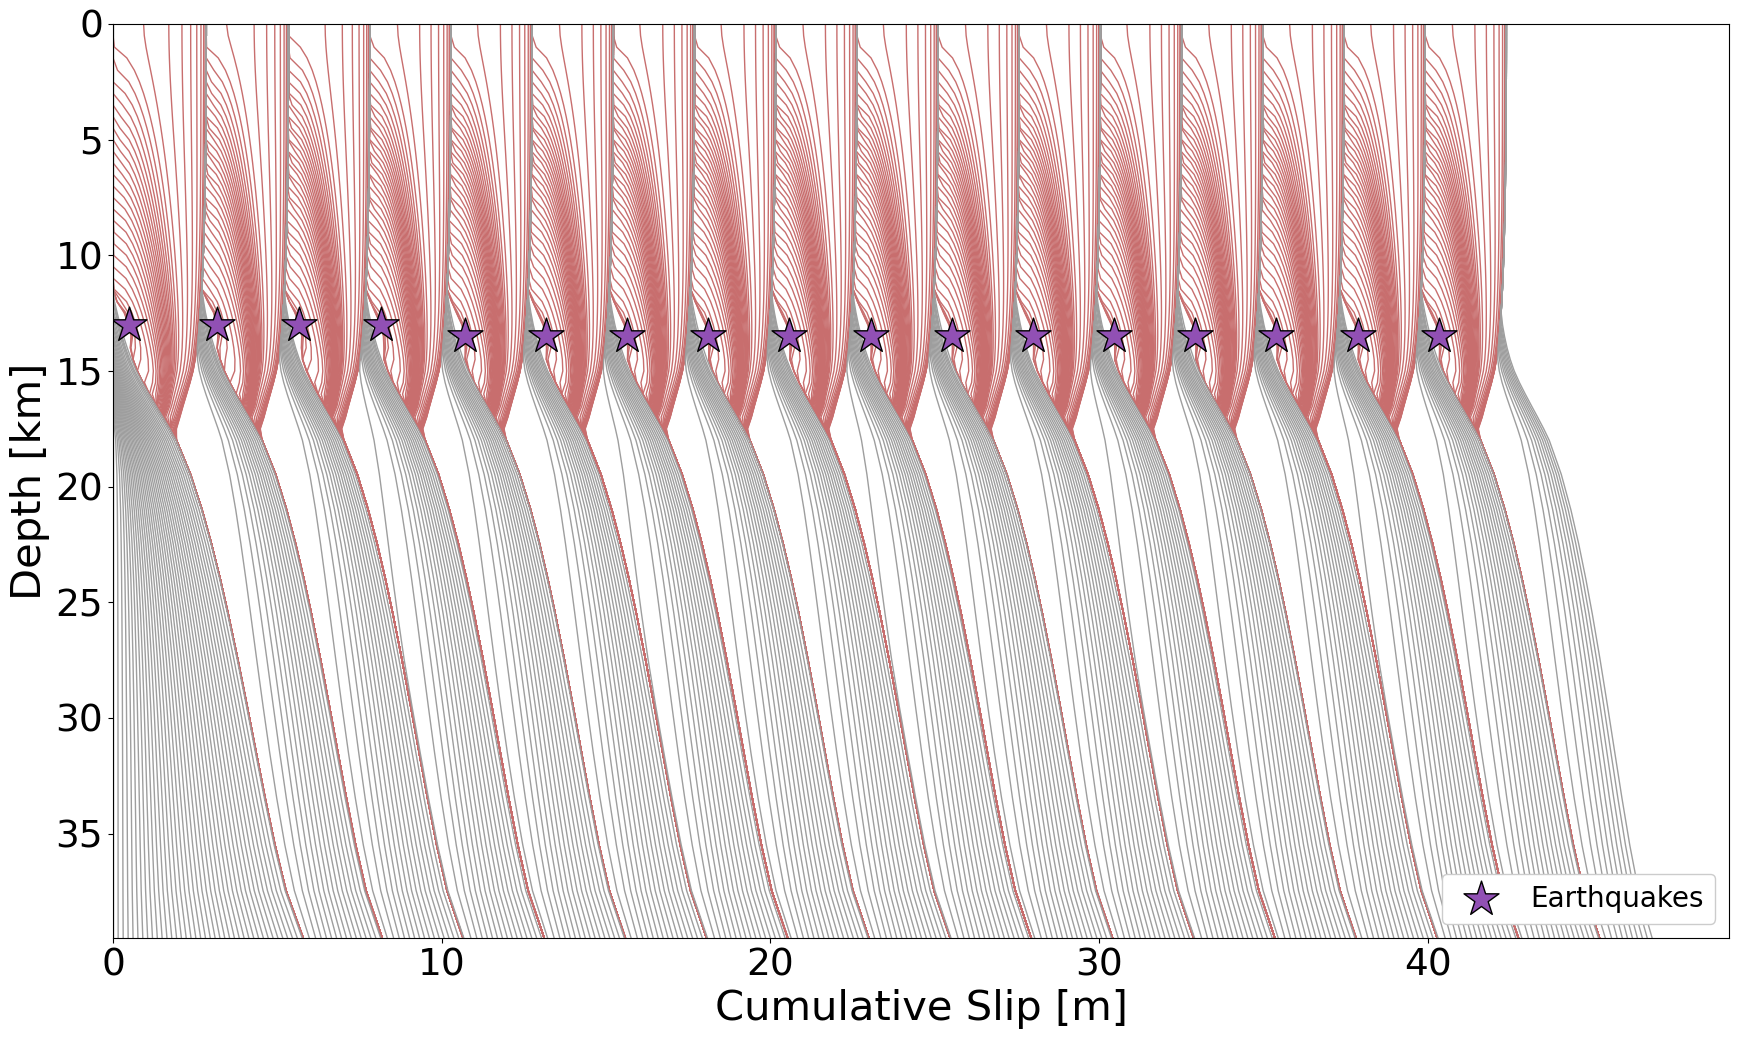

In [5]:
from cumslip_plot import only_cumslip
from cumslip_compute import compute_cumslip

# Define input parameters
options = {
    'dt_creep' : 5*yr2sec,         # Time interval for interseismic slip contour [s]
    'dt_coseismic' : 1,            # Time interval for coseismic slip contour [s],
    'save_on' : False,             # Whether to save the figure in png format or not
}

# Compute cumulative slip outputs
cumslip_outputs = compute_cumslip(var, event_info, **options)

# Plot the result
only_cumslip(cumslip_outputs, event_info, save_dir=save_dir, **options)

## Plot spatiotemporal evolution of on-fault variables

The following cells plot the spatiotemporal evolution of on-fault variables, including shear stress, normal stress, changes in shear or normal stresses, state variable ($\phi$), slip, and slip rate. The dropdown menu `Evolution type` defines the target variable you wish to plot.

In [6]:
from faultoutputs_image import fout_image

options = {
    'sys_col' : (70/255,225/255,165/255),         # Color of markers indicating earthquake events
    'plot_in_timestep': True,                     # Whether to plot x-axis in timestep. Default is in physical time, in years
    'plot_in_sec': False,                         # If x-axis in physical time, whether to plot it in seconds. Default is in years
    'save_on': False                              # Whether to save the figure in png format
}

dropdown, info_label, get_selected_evolution_type = select_evolution_type()
display(dropdown, info_label)

Dropdown(description='Evolution type:', layout=Layout(width='300px'), options=('', 'State Variable', 'Cumulati…

Label(value='No type selected yet')

Best color map for each plot is pre-defined in `faultoutputs_image.py`. For example, the colormap for the slip rate plots is designed to better illustrate different rupture speeds:
- Red: coseismic slip rate
- Yellow: aseismic slip rate comparable to the reference slip rate ($V_0$)
- Blue: stable creep of about plate loading rate ($V_p$)
- Black: locked

Full image
Plot in time steps
Full image


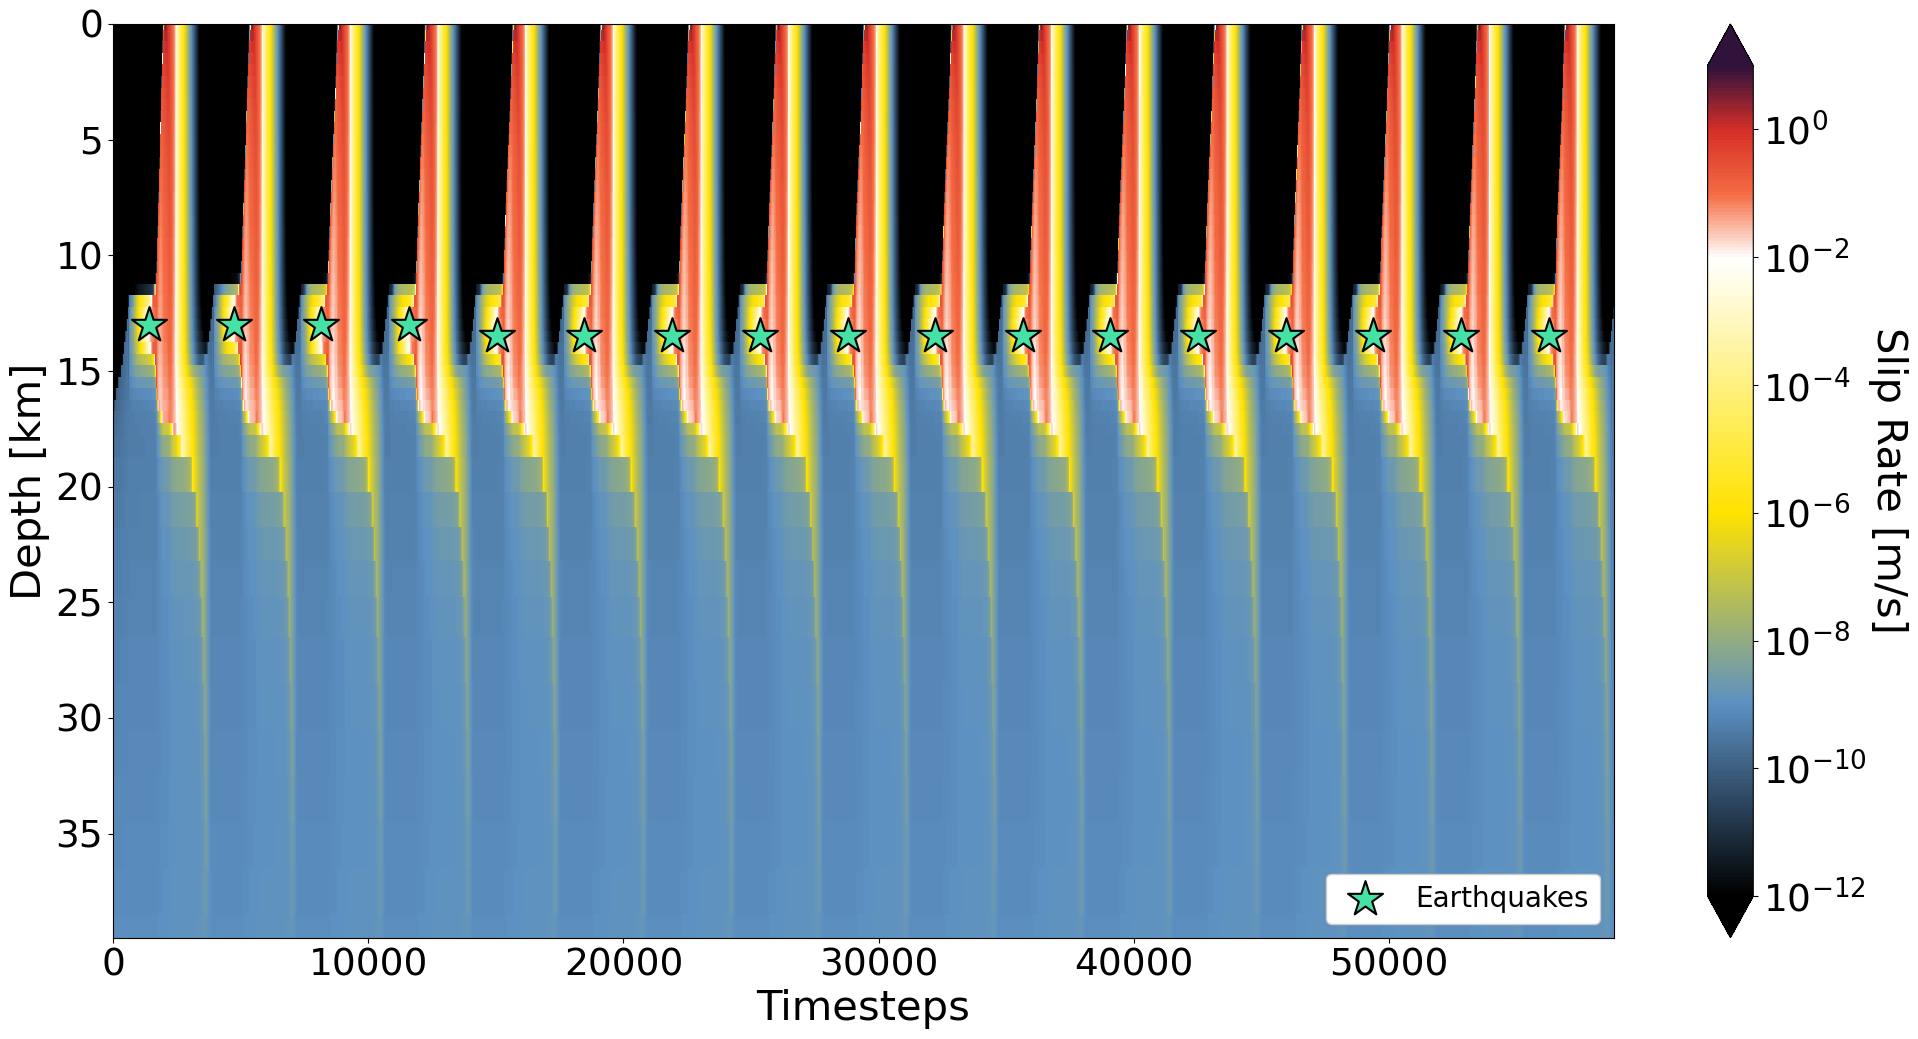

In [7]:
evolution_type, target_variable = get_selected_evolution_type()
options['target_variable'] = target_variable
fout_image(var, event_info, save_dir=save_dir, **options)

## Plot time series of an on-fault variable

The following cells plot timeseries of on-fault variables, including shear stress, normal stress, state variable ($\phi$), slip, and slip rate. The dropdown menu `Time series type` defines the target variable you wish to plot. If a floating number is given for the `target_loc`, the time series is plotted at the given depth. Otherwise (i.e., if `target_loc` is `None`), the peak value along the entire fault will be plotted.

In [ ]:
options = {
    # 'target_loc': None,           # If None, plots peak value across the fault
    'target_loc': 7.5,              # If a float is given, plot value at nearest on-fault probe
    'plot_in_sec': False,           # Plot time in seconds. Default is in years
    'ylim': False,                  # Custom Y-axis limit
    'save_on': False,               # Whether to save the figure in png format
}

dropdown, info_label, get_selected_timeseries_type = select_timeseries_type()
display(dropdown, info_label)

Dropdown(description='Time series type:', layout=Layout(width='300px'), options=('', 'State Variable', 'Cumula…

Label(value='No type selected yet')

Create figure
At 7.5 km Depth


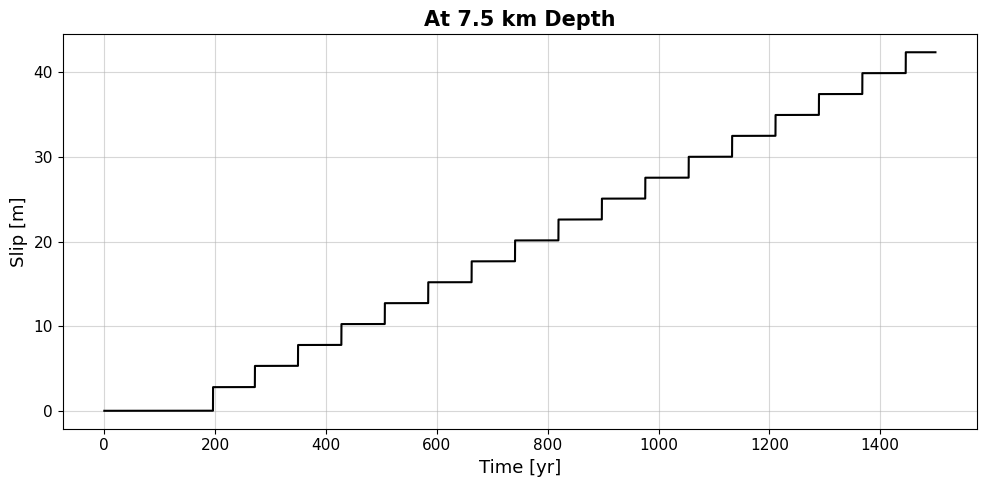

In [9]:
timeseries_type, target_variable = get_selected_timeseries_type()
options['target_variable'] = target_variable
var.timeseries(target_variable, **options)

## Plot mesh

Now, let's learn how to check our input files. The input mesh size can be displayed using the following cells. The mesh file (`.msh` file) used for the simulation will automatically be selected from the output directory. In the following plot, boundaries are colored according to the imposed boundary conditions:
- Light blue: free surface boundary condition
- Black: fault, governed by rate-and-state friction
- Pink: Dirichlet boundary condition. Displacements along these boundaries are pre-defined in `boundary` function in the `.lua` file

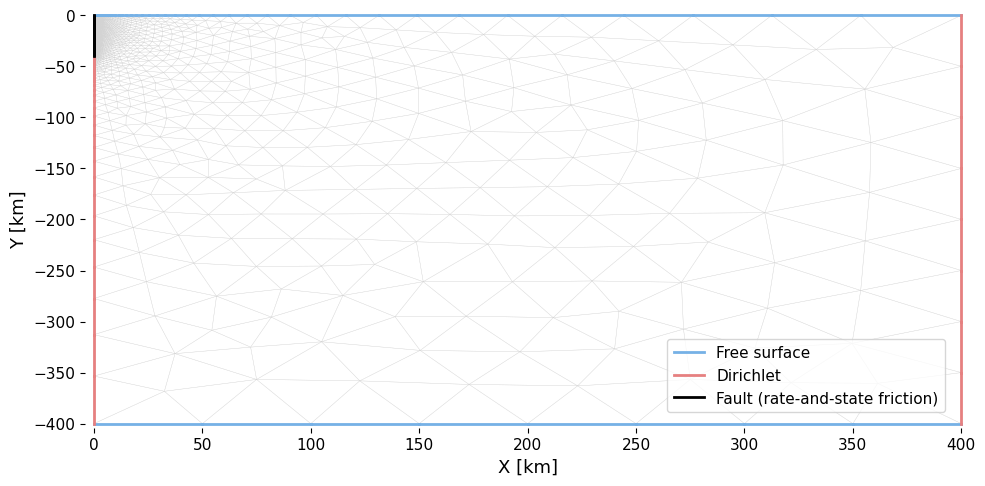

In [10]:
from read_mesh import GmshMesh2D
mesh_path = select_mesh(save_dir=save_dir)
my_mesh = GmshMesh2D(mesh_path)
my_mesh.plot_physical_curves()

## Plot variables defined in the material file

Finally, let's plot the functions defining material and frictional properties. The `.lua` file used for the simulation can be called in python using `LuaRuntime` from a package called `lupa`. For this, this script automatically detect the parameter file (`.toml` file) used for the simulation, which defines the lua library (`lib` in the `.toml` file) and the scenario (`scenario` in the `.toml` file). Information about lua library will be automatically extracted from given parameter file:

In [11]:
lua_lib_name, lua_scenario_name = select_lua_scenario(save_dir=save_dir)

print('Selected Lua library: \"%s\"'%(lua_lib_name))
print('Selected Lua scenario: \"%s\"'%(lua_scenario_name))

Selected Lua library: "bp1.lua"
Selected Lua scenario: "bp1"


Now, let's load functions and variables in the `.lua` file using `lupa` package:

In [12]:
import os
from lupa import LuaRuntime

# Initiate Lua callback
lua = LuaRuntime()

# Open and read Lua file
with open(os.path.join(save_dir, lua_lib_name), "r") as f:
    lua_code = f.read()
lua.execute(lua_code)                                   # execute lines in Lua

# Access a specific scenario
scenario = getattr(lua.globals(), lua_scenario_name)

# Variables defined in the Lua scenario can be accessed. E.g.,
print('amax =',scenario.amax)                           # constant 'amax'
print('mu(0, 10) =',scenario.mu(scenario, 0, 10))       # function 'mu(x, y)', executed at (x, y) = (0, 10)


amax = 0.025
mu(0, 10) = 32.03812032


Use this feature to plot variables defined along depth. This cell shows how to access the initial normal stress (function `sn_pre(x, y)` in `.lua` file), the rate-and-state parameters (function `a(x, y)` and constant `b` in `.lua` file), and the characteristic state evolution distance (function `L(x, y)` in `.lua` file). Later, you can modify the fields based on your interest.

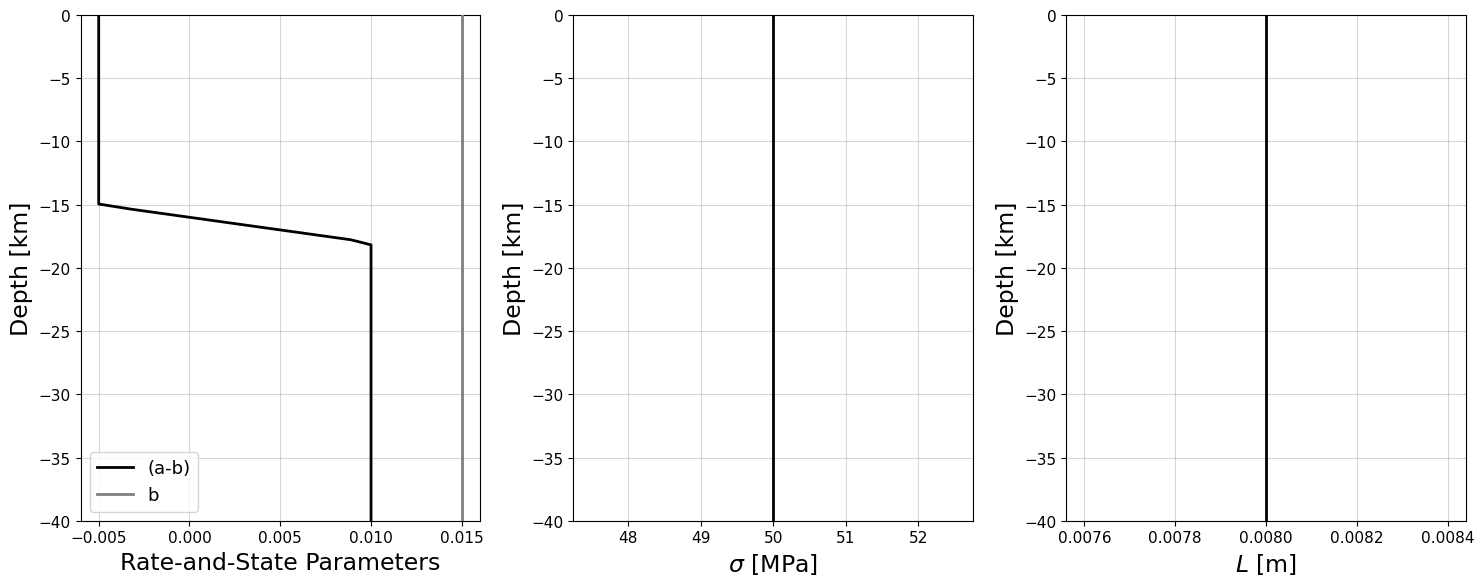

In [13]:
# Whether or not to save the figure
save_plot = False

# Set depth and distance ranges
depth = np.linspace(0, -40, 100)                                        # Execute along 100 points from 0 km to 40 km depth

# Rate-and-state parameters
scenario_a = [scenario.a(scenario, 0, d) for d in depth]                # Extract rate-and-state parameter, a
scenario_b = scenario.b * np.ones(len(scenario_a))                      # Extract rate-and-state parameter, b
scenario_ab = scenario_a - scenario_b                                   # Extract rate-and-state parameter, a-b

# Initial normal stress
scenario_snpre = [scenario.sn_pre(scenario, 0, d) for d in depth]       # Extract initial normal stress

# Characteristic state evolution distance, L
scenario_L = [scenario.L(scenario, 0, d) for d in depth]                # Extract characteristic state evolution distance

# Plot results using imshow
fig, [ax, ax2, ax3] = plt.subplots(ncols=3, figsize=(15, 6))            # Initiate a plot with three panels

ax.plot(scenario_ab, depth, 'k', label='(a-b)', lw=2, zorder=3)         # Rate-and-state parameter, a-b
ax.plot(scenario_b, depth, '0.5', label='b', lw=2, zorder=3)            # Rate-and-state parameter, b
ax.legend(fontsize=13)
ax.set_xlabel('Rate-and-State Parameters', fontsize=17)
ax.set_ylabel('Depth [km]', fontsize=17)
ax.set_ylim(-40, 0)
ax.grid(True, alpha=0.5)

ax2.plot(scenario_snpre, depth, 'k', lw=2, zorder=3)                     # Initial normal stress
ax2.set_xlabel(r'$\sigma$ [MPa]', fontsize=17)
ax2.set_ylabel('Depth [km]', fontsize=17)
ax2.set_ylim(-40, 0)
ax2.grid(True, alpha=0.5)

ax3.plot(scenario_L, depth, 'k', lw=2, zorder=3)                         # Characteristic state evolution distance
ax3.set_xlabel('$L$ [m]', fontsize=17)
ax3.set_ylabel('Depth [km]', fontsize=17)
ax3.set_ylim(-40, 0)
ax3.grid(True, alpha=0.5)

plt.tight_layout()
if save_plot:
    plt.savefig('%s/frictional_parameters.png'%(save_dir), dpi=300)     # If save_plot is True, save the plot in png format
plt.show()

# Closing remarks

For more informations about running Tandem models, please checkout the [Tandem documentation](https://tandem.readthedocs.io/en/latest/index.html). We welcome your contribution on the visualization tools through the [github repository](https://github.com/TEAR-ERC/tandem-tools/tree/main/visualization/using_jupyter_notebook). Example usages of these Tandem output visualizations can be found the following paper:

Yun, J., Gabriel, A.-A., May, D. A., & Fialko, Y. (2025). Effects of stress and friction heterogeneity on spatiotemporal complexity of seismic and aseismic slip on strike-slip faults. Journal of Geophysical Research: Solid Earth, 130, e2025JB031270. [https://doi.org/10.1029/2025JB031270](https://doi.org/10.1029/2025JB031270)